<a href="https://colab.research.google.com/github/DiyaSmitha/ictak_exit_test/blob/main/ICTAK_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

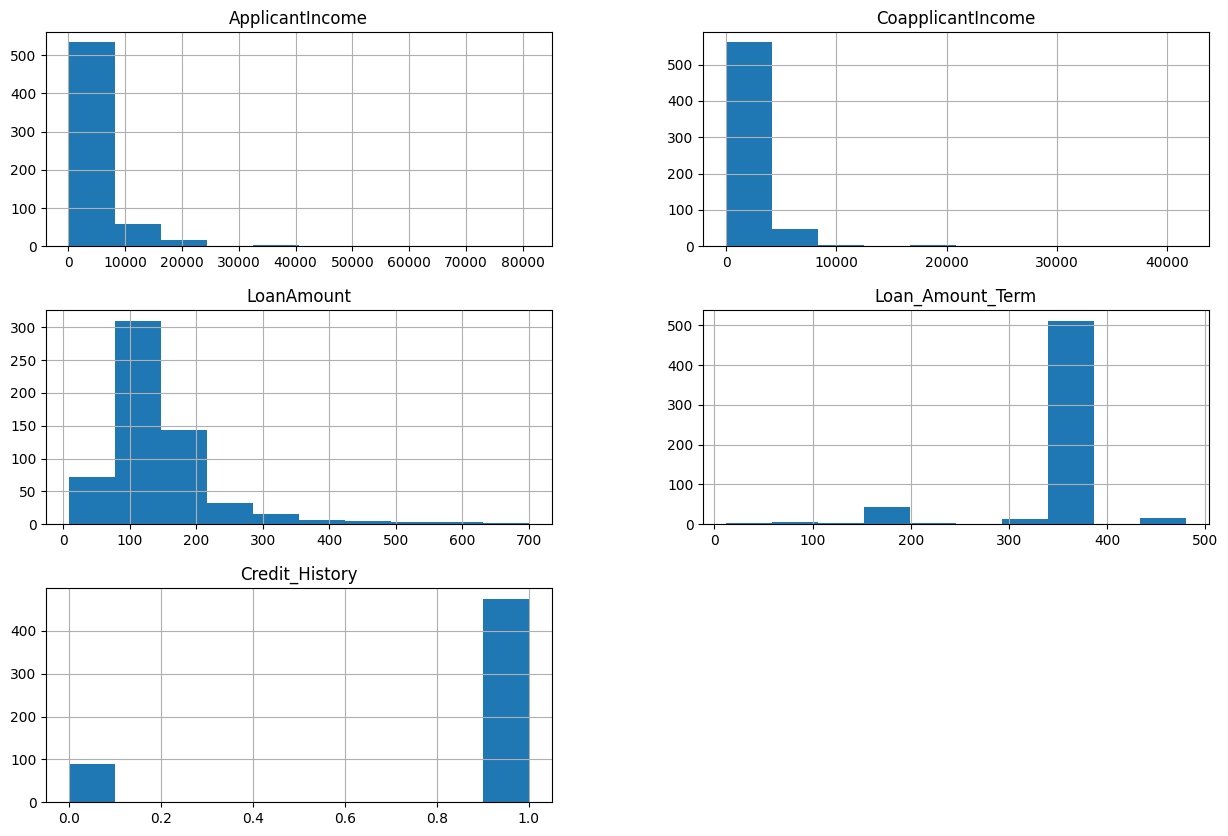

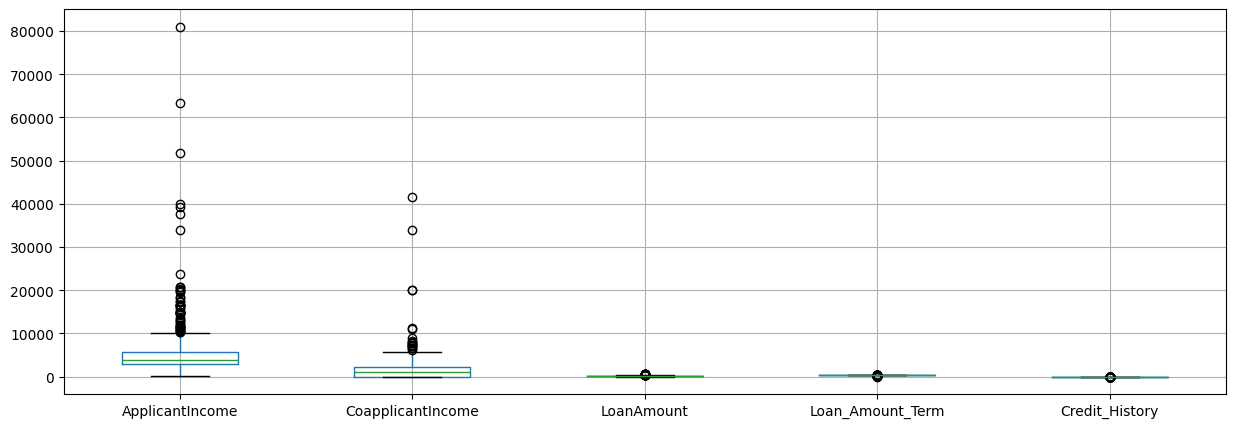

       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000         600.00000   
mean       5403.459283        1621.245798  146.412162         342.00000   
std        6109.041673        2926.248369   85.587325          65.12041   
min         150.000000           0.000000    9.000000          12.00000   
25%        2877.500000           0.000000  100.000000         360.00000   
50%        3812.500000        1188.500000  128.000000         360.00000   
75%        5795.000000        2297.250000  168.000000         360.00000   
max       81000.000000       41667.000000  700.000000         480.00000   

       Credit_History  
count      564.000000  
mean         0.842199  
std          0.364878  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          1.000000  


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Cross-Validation Accuracy: 0.81 ± 0.04
Accuracy: 0.7804878048780488

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.42      0.57        43
           1       0.76      0.97      0.85        80

    accuracy                           0.78       123
   macro avg       0.83      0.70      0.71       123
weighted avg       0.81      0.78      0.75       123

Predictions saved to loan_prediction_submission.csv


<ipython-input-1-739318905d9c>:91: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  testdf[column].fillna(testdf[column].mode()[0], inplace=True)
<ipython-input-1-739318905d9c>:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=Tru

In [1]:
# -*- coding: utf-8 -*-
"""PROJECT_FINAL.ipynb"""

# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data = pd.read_csv("train.csv")

# Exploratory Data Analysis
data.hist(figsize=(15, 10))
plt.show()
data.boxplot(figsize=(15, 5))
plt.show()
print(data.describe())

# Preprocess data
# 1. Handling missing values for numerical columns
numerical_imputer = SimpleImputer(strategy='mean')
data[['LoanAmount', 'Loan_Amount_Term']] = numerical_imputer.fit_transform(data[['LoanAmount', 'Loan_Amount_Term']])

# Replace '3+' in Dependents with 3 to make it numerical
data['Dependents'] = data['Dependents'].replace('3+', 3).astype(float)

# 2. Encoding categorical variables consistently
label_encoder = LabelEncoder()
for column in ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']:
    data[column] = label_encoder.fit_transform(data[column])

# Split data into features and target variable
X = data.drop(columns=['Loan_ID', 'Loan_Status'])
y = data['Loan_Status']

# Define numerical columns for scaling
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the numerical features
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Hyperparameter tuning for RandomForestClassifier
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           n_jobs=-1,
                           scoring='accuracy')
grid_search.fit(X_train, y_train)

# Retrieve the best model from grid search
model = grid_search.best_estimator_

# Cross-validation to evaluate model performance
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Train the model with the best hyperparameters
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("\nClassification Report:\n", report)

# Preparing test data
testdf = pd.read_csv("test.csv")

# Handle missing values in test data
for column in ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']:
    testdf[column].fillna(testdf[column].mode()[0], inplace=True)
testdf['LoanAmount'].fillna(testdf['LoanAmount'].median(), inplace=True)
testdf['Loan_Amount_Term'].fillna(testdf['Loan_Amount_Term'].median(), inplace=True)
testdf['Dependents'] = testdf['Dependents'].replace('3+', 3).astype(float)

# Encode categorical variables in test data
for column in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']:
    testdf[column] = label_encoder.fit_transform(testdf[column])

# Scale numerical features in test data using the scaler fitted on training data
X_test_final = testdf.drop(columns=['Loan_ID'])
X_test_final[numerical_cols] = scaler.transform(X_test_final[numerical_cols])

# Make predictions on the final test data
y_pred_test = model.predict(X_test_final)

# Create a new DataFrame with Loan_ID and predicted Loan_Status
submission_df = pd.DataFrame({'Loan_ID': testdf['Loan_ID'], 'Loan_Status': y_pred_test})

# Map the predicted Loan_Status back to 'Y' and 'N'
submission_df['Loan_Status'] = submission_df['Loan_Status'].map({1: 'Y', 0: 'N'})

# Save the predictions to a CSV file
submission_df.to_csv('loan_prediction_submission.csv', index=False)

print("Predictions saved to loan_prediction_submission.csv")
